## PINN example: learning a modulated oscillation with Fourier features

In this example we demonstrate how a Physics-Informed Neural Network (PINN) can learn a **non-trivial oscillatory function** without any training data, using only a governing differential equation, anchor conditions, and a representation adapted to periodic structure.

---

### Target function

We consider the function

$$
y(x) = \cos\!\left(\frac{x}{10}\right)\,\sin(x),
$$

which represents a fast oscillation modulated by a slow envelope. This function is *not* a single Fourier mode, but a superposition of nearby frequencies.

---

### Governing differential equation

Using trigonometric identities, the target function can be written as a sum of two sine modes with frequencies

$$
\omega_1 = \frac{9}{10},
\qquad
\omega_2 = \frac{11}{10}.
$$

As a consequence, $y(x)$ satisfies the fourth-order linear ODE

$$
\bigl(D^2 + \omega_1^2\bigr)\bigl(D^2 + \omega_2^2\bigr)y = 0,
$$

which expands to

$$
y^{(4)}(x)
+ \frac{101}{50}\,y''(x)
+ \frac{9801}{10000}\,y(x)
= 0.
$$

This ODE is enforced everywhere in the training domain via the PINN loss.

---

### Uniqueness via anchor conditions

Because the equation is fourth order, four conditions are required to select the desired solution. They are imposed at $x=0$:

$$
y(0)=0,\qquad
y'(0)=1,\qquad
y''(0)=0,\qquad
y^{(3)}(0)=-\frac{103}{100}.
$$

These anchor conditions uniquely fix the target function among all solutions of the ODE.

---

### PINN setup with Fourier features

- **Training domain:** $[0,\;7\pi]$
- **Evaluation domain:** $[-8\pi,\;8\pi]$
- **Neural network:** MLP operating on a fixed Fourier feature map  
  $x \mapsto \bigl(\sin(\omega_k x), \cos(\omega_k x)\bigr)$
- **Loss:** ODE residual + anchor condition penalties
- **No data values** $y(x)$ are used during training

Fourier features align the network representation with the oscillatory structure of the solution and significantly improve extrapolation.

After training, the learned solution is compared to the analytical target function on an extended domain, and the result is saved as `pinn_sine_cosine.png`.

This example illustrates how PINNs can recover structured, multi-frequency solutions purely from physics constraints when the representation is chosen appropriately.

device: mps
ep    1 | total=5.981e+02 | ode=3.866e+02
ep  500 | total=5.224e-02 | ode=5.137e-02
ep 1000 | total=1.543e-02 | ode=1.524e-02
ep 1500 | total=9.901e-03 | ode=9.806e-03
ep 2000 | total=7.226e-03 | ode=6.651e-03
ep 2500 | total=2.444e-02 | ode=5.900e-03
ep 3000 | total=3.045e-02 | ode=4.654e-03
ep 3500 | total=3.559e-03 | ode=3.542e-03
ep 4000 | total=3.680e-03 | ode=2.997e-03
ep 4500 | total=1.187e-01 | ode=4.667e-03
ep 5000 | total=1.704e-03 | ode=1.423e-03


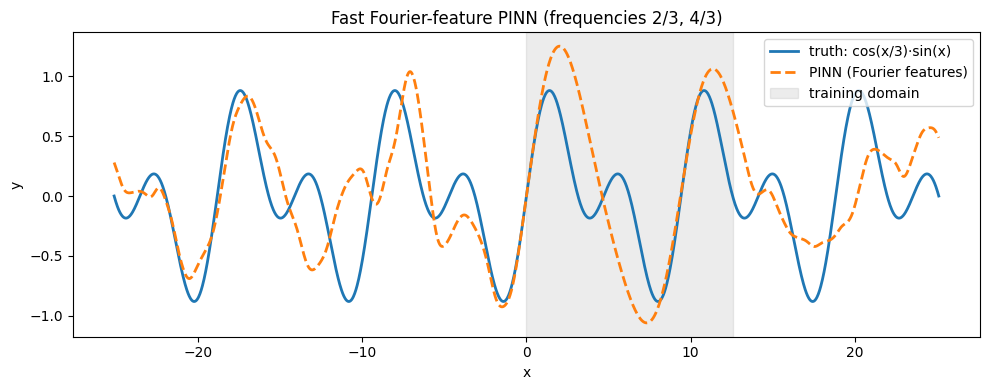

In [11]:
# ------------------------------------------------------------
# Fast PINN with Fourier features
# Target: y(x) = cos(x/3) * sin(x)
# Train on [0, 4π], evaluate on [-8π, 8π]
# ------------------------------------------------------------
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device:", device)

# ------------------------------------------------------------
# Target function
# ------------------------------------------------------------
def y_true(x):
    return torch.cos(x / 3.0) * torch.sin(x)

# ------------------------------------------------------------
# Governing ODE
# (D^2 + (2/3)^2)(D^2 + (4/3)^2) y = 0
# => y'''' + (20/9) y'' + (64/81) y = 0
# ------------------------------------------------------------
c2 = 20.0 / 9.0
c0 = 64.0 / 81.0

# ------------------------------------------------------------
# Fourier-feature MLP (small + focused)
# ------------------------------------------------------------
class FourierMLP(nn.Module):
    def __init__(self, m=12, max_freq=2.0, width=64, depth=1):
        super().__init__()

        omegas = torch.linspace(0.5, max_freq, m).view(1, m)
        self.register_buffer("omegas", omegas)

        in_dim = 2 * m
        layers = [nn.Linear(in_dim, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

        for mod in self.net:
            if isinstance(mod, nn.Linear):
                nn.init.xavier_normal_(mod.weight)
                nn.init.zeros_(mod.bias)

    def features(self, x):
        z = x * self.omegas
        return torch.cat([torch.sin(z), torch.cos(z)], dim=1)

    def forward(self, x):
        return self.net(self.features(x))

model = FourierMLP().to(device)

# ------------------------------------------------------------
# Autograd helper
# ------------------------------------------------------------
def nth_derivative(y, x, n):
    out = y
    for _ in range(n):
        out = torch.autograd.grad(
            out, x,
            grad_outputs=torch.ones_like(out),
            create_graph=True
        )[0]
    return out

# ------------------------------------------------------------
# Training domain [0, 4π]
# ------------------------------------------------------------
x_min, x_max = 0.0, 4.0 * math.pi
N_col = 256

def sample_collocation(n):
    x = x_min + (x_max - x_min) * torch.rand(n, 1, device=device)
    x.requires_grad_(True)
    return x

# ------------------------------------------------------------
# Anchor conditions at x = 0
# y(0)=0, y'(0)=1, y''(0)=0, y'''(0)=-2/3
# ------------------------------------------------------------
x0 = torch.tensor([[0.0]], device=device, requires_grad=True)

y0_t = torch.tensor([[0.0]], device=device)
y1_t = torch.tensor([[1.0]], device=device)
y2_t = torch.tensor([[0.0]], device=device)
y3_t = torch.tensor([[-2.0 / 3.0]], device=device)

# ------------------------------------------------------------
# Optimizer
# ------------------------------------------------------------
opt = torch.optim.Adam(model.parameters(), lr=2e-3)
w_ode = 1.0
w_ic  = 30.0

# ------------------------------------------------------------
# Training loop
# ------------------------------------------------------------
steps = 5000
for ep in range(1, steps + 1):
    opt.zero_grad()

    x = sample_collocation(N_col)
    y = model(x)

    y2 = nth_derivative(y, x, 2)
    y4 = nth_derivative(y, x, 4)
    r = y4 + c2 * y2 + c0 * y
    loss_ode = torch.mean(r**2)

    y0 = model(x0)
    y1 = nth_derivative(y0, x0, 1)
    y2_0 = nth_derivative(y0, x0, 2)
    y3_0 = nth_derivative(y0, x0, 3)

    loss_ic = (
        (y0   - y0_t).pow(2).mean() +
        (y1   - y1_t).pow(2).mean() +
        (y2_0 - y2_t).pow(2).mean() +
        (y3_0 - y3_t).pow(2).mean()
    )

    loss = w_ode * loss_ode + w_ic * loss_ic
    loss.backward()
    opt.step()

    if ep % 500 == 0 or ep == 1:
        print(f"ep {ep:4d} | total={loss.item():.3e} | ode={loss_ode.item():.3e}")

# ------------------------------------------------------------
# Evaluation on [-8π, 8π]
# ------------------------------------------------------------
model.eval()
xx = torch.linspace(-8*math.pi, 8*math.pi, 2000, device=device).view(-1, 1)

with torch.no_grad():
    yp = model(xx)
    yt = y_true(xx)

xx_cpu = xx.cpu().numpy().ravel()
yp_cpu = yp.cpu().numpy().ravel()
yt_cpu = yt.cpu().numpy().ravel()

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(xx_cpu, yt_cpu, label="truth: cos(x/3)·sin(x)", linewidth=2)
plt.plot(xx_cpu, yp_cpu, "--", label="PINN (Fourier features)", linewidth=2)
plt.axvspan(0, 4*math.pi, color="gray", alpha=0.15, label="training domain")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fast Fourier-feature PINN (frequencies 2/3, 4/3)")
plt.tight_layout()
plt.savefig("pinn_sine_cosine.png")
plt.show()
